# DHF - Lab 6 - Mathematical LOB modellingFichier

*Pierre ARTIGALA - Léon CHATAIGNAULT*
<a id='top'></a>

## Table of contents

### [0. Model](#q0)
### [1. Sanity check](#q1)
### [2. Main analysis](#q2)


## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.special import kolmogorov
from functools import partial
from scipy.stats import expon
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

<a id='q0'></a>

## 0. Model [[^]](#top)

Modeling assumptions :

The model used in this lab is a variant the Poisson models presented above. Price is constrained on a fixed grid $\{0, ..., N−1\}$. By convention, bid quantities are negative, ask quantities are positive. All orders are supposed to be of size 1. The limit order book is thus a vector X of size N with signed integers values.

In [ ]:
def model_lob(
    N: int,
    K: int,
    mu: float,
    lambd: float,
    theta: float,
    X_0: np.array,
    T: float,
):
    """Run a simulation of the LOB model."""
    # Initialization
    t = 0
    X = X_0.copy()
    # Matrix in which the LOB history will be saved
    data = [X_0]
    l_delta = [0]
    # Iterations to modify the LOB
    while t < T:
        # Compute the bid and ask prices
        p_bid = np.where(X<0)[0].max()
        p_ask = np.where(X>0)[0].min()
        # Set the active windows (A for ask and B for bid)
        id_A = np.arange(p_bid+1, p_bid+K+1)
        id_B = np.arange(p_ask-K, p_ask)
        B = X[id_B]
        A = X[id_A]
        # Set the intensity vector
        norm_A = np.abs(A).sum()
        norm_B = np.abs(B).sum()
        intensity = np.array([mu, mu, K*lambd, K*lambd, theta*norm_B, theta*norm_A])
        # Draw delta the time interval to the next event (exponential with rate norm(intensity))
        norm_intensity = np.abs(intensity).sum()
        delta = np.random.exponential(scale = 1/norm_intensity)
        # Decide the type of the next event according to the intensity vector
        proba = intensity / norm_intensity
        next_event = np.random.choice(np.arange(0, len(intensity)), p=proba)
        # Modify the LOB according to the event
        if next_event == 0:
            # Process a bid market order
            X[p_bid] +=1
        elif next_event == 1:
            # Process an ask market order
            X[p_ask] -=1
        elif next_event == 2:
            # Process a bid limit order
            # Choose a price in B with uniform distribution
            p_event = np.random.choice(id_B)
            # Add a bid limit order at this price
            X[p_event] -= 1
        elif next_event == 3:
            # Process an ask limit order
            # Choose a price in A with uniform distribution
            p_event = np.random.choice(id_A)
            # Add an ask limit order at this price
            X[p_event] += 1
        elif next_event == 4:
            # Process a bid cancellation
            # Choose an order to be cancelled with probability proportional to the coordinates of B
            proba = np.abs(B)/norm_B
            p_event = np.random.choice(id_B, p=proba)
            # Cancel an order at the chosen price
            X[p_event] += 1
        else:
            # Process an ask cancellation
            # Choose an order to be cancelled with probability proportional to the coordinates of A
            proba = np.abs(A)/norm_A
            p_event = np.random.choice(id_A, p=proba)
            # Cancel an order at the chosen price
            X[p_event] -= 1
        t += delta
        # Append the current state to the dataframe (if t<=T)
        if t <= T:
            l_delta.append(t)
            data.append(X.copy())
    # Create a dataframe to save the LOB history
    df = pd.DataFrame(data=data, index=l_delta)
    # Save the dataframe
    df.to_csv("results_lob.csv", index=True)
    return df

def load_results():
    """Load the .csv file."""
    df = pd.read_csv("results_lob.csv", index_col=0)
    return df

In [ ]:
N = 1000
K = 10
mu = 2.5
lambd = 1
theta = 0.2
X_0 = np.array([-5 for _ in range(int(N/2))] + [5 for _ in range(int(N/2))])
T = 10**2

df = model_lob(
    N=N,
    K=K,
    mu=mu,
    lambd=lambd,
    theta=theta,
    X_0=X_0,
    T=T
)

<a id='q1'></a>

## 1. Sanity check [[^]](#top)

### 1.1 Print a small extract of the csv output of the simulation to illustrate that the orders are correctly processed.

In [ ]:
df = load_results()
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0.000000,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
0.016131,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
0.041325,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
0.061626,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
0.063482,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.893355,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
99.894631,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
99.897231,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5
99.947011,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,5,5,5,5,5,5,5,5,5,5


### 1.2 Check that the number of bid and ask market and limit orders in the simulation is correct (in agreement with the intensity parameters) and that the placement of limit orders in the simulation is correct (uniform distribution).

In [ ]:
def model_lob_temp(
    N: int,
    K: int,
    mu: float,
    lambd: float,
    theta: float,
    X_0: np.array,
    T: float,
):
    """
    Run a simulation of the LOB model.
    Records the distribution of arrival times and 
    """
    # Initialization
    t = 0.
    t_last_market_bid = 0.
    t_last_market_ask = 0.
    t_last_limit_ask = 0.
    t_last_limit_bid = 0.
    X = X_0.copy()
    stats = {
             "placement limit bid":[0]*K,
             "placement limit ask":[0]*K,
             "times arrival market bid":[],
             "times arrival market ask":[],
             "times arrival limit bid":[],
             "times arrival limit ask":[],
             }
    # Matrix in which the LOB history will be saved
    data = [X_0]
    l_delta = [0]
    # Iterations to modify the LOB
    while t < T:
        # Compute the bid and ask prices
        p_bid = np.where(X<0)[0].max()
        p_ask = np.where(X>0)[0].min()
        # Set the active windows (A for ask and B for bid)
        id_A = np.arange(p_bid+1, p_bid+K+1)
        id_B = np.arange(p_ask-K, p_ask)
        B = X[id_B]
        A = X[id_A]
        # Set the intensity vector
        norm_A = np.abs(A).sum()
        norm_B = np.abs(B).sum()
        intensity = np.array([mu, mu, K*lambd, K*lambd, theta*norm_B, theta*norm_A])
        # Draw delta the time interval to the next event (exponential with rate norm(intensity))
        norm_intensity = np.abs(intensity).sum()
        delta = np.random.exponential(scale = 1/norm_intensity)
        # Decide the type of the next event according to the intensity vector
        proba = intensity / norm_intensity
        next_event = np.random.choice(np.arange(0, len(intensity)), p=proba)
        # Modify the LOB according to the event
        if next_event == 0:
            # Process a bid market order
            X[p_bid] +=1
            stats["times arrival market bid"]+=[t+delta-t_last_market_bid]
            t_last_market_bid = t+delta
        elif next_event == 1:
            # Process an ask market order
            X[p_ask] -=1
            stats["times arrival market ask"]+=[t+delta-t_last_market_ask]
            t_last_market_ask = t+delta
        elif next_event == 2:
            # Process a bid limit order
            # Choose a price in B with uniform distribution
            p_event = np.random.choice(id_B)
            # Add a bid limit order at this price
            X[p_event] -= 1
            stats["placement limit bid"][p_event-p_ask+K] += 1
            stats["times arrival limit bid"]+=[t+delta-t_last_limit_bid]
            t_last_limit_bid = t+delta
        elif next_event == 3:
            # Process an ask limit order
            # Choose a price in A with uniform distribution
            p_event = np.random.choice(id_A)
            # Add an ask limit order at this price
            X[p_event] += 1
            stats["placement limit ask"][p_event-p_bid-1] += 1
            stats["times arrival limit ask"]+=[t+delta-t_last_limit_ask]
            t_last_limit_ask = t+delta
        elif next_event == 4:
            # Process a bid cancellation
            # Choose an order to be cancelled with probability proportional to the coordinates of B
            proba = np.abs(B)/norm_B
            p_event = np.random.choice(id_B, p=proba)
            # Cancel an order at the chosen price
            X[p_event] += 1
        else:
            # Process an ask cancellation
            # Choose an order to be cancelled with probability proportional to the coordinates of A
            proba = np.abs(A)/norm_A
            p_event = np.random.choice(id_A, p=proba)
            # Cancel an order at the chosen price
            X[p_event] -= 1
        t += delta
        # Append the current state to the dataframe (if t<=T)
        if t <= T:
            l_delta.append(t)
            data.append(X.copy())
    # Create a dataframe to save the LOB history
    df = pd.DataFrame(data=data, index=l_delta)
    # Save the dataframe
    df.to_csv("results_lob.csv", index=True)
    return df, stats

def load_results():
    """Load the .csv file."""
    df = pd.read_csv("results_lob.csv", index_col=0)
    return df

In [ ]:
df, stats = model_lob_temp(
    N=N,
    K=K,
    mu=mu,
    lambd=lambd,
    theta=theta,
    X_0=X_0,
    T=T,
)

In [ ]:
def KS_test_discrete_uniform(dist:list, K:int):
    """Kolmogorov-Smirnov test for a discrete-value uniform distribution, K being the number of distinct values"""
    n = np.sum(dist)
    # empirical cumulative distribution function
    emp_cdf = np.cumsum(dist)/n
    # cdf KS distance
    KS_dist = np.max([np.abs(emp_cdf[i]-(i+1)/K) for i in range(K)])
    # p value of the sample
    pvalue = kolmogorov(np.sqrt(n)*KS_dist)
    return pvalue

def KS_test_exponential(dist:list, lambd:float):
    """Kolmogorov-Smirnov test for exponential distribution"""
    n = len(dist)
    # empirical cumulative distribution function
    emp_ppf = sorted(dist)
    # theoretical cumultaive distribution function
    th_cdf = partial(expon.cdf, scale=1/lambd)
    # cdf KS distance
    dist_inf = max([np.abs(k/n-th_cdf(emp_ppf[k])) for k in range(n)])
    dist_sup = max([np.abs((k+1)/n-th_cdf(emp_ppf[k])) for k in range(n)])
    KS_dist = max(dist_sup, dist_inf)
    # p value of the sample
    pvalue = kolmogorov(np.sqrt(n)*KS_dist)
    return pvalue

def verify_stats(stats:dict, T:int, K:int, lambd:float, mu:float, conf:float,):
    """
    Verify if the statistics are likely to be drawn from a valid distribution :
    - The number of orders per category should approximate the expetancy of each poisson process
    - The distibution of the limit orders should be uniform (KS test)
    """
    # initialise result table
    res = pd.DataFrame(
        columns=["p value", "rejected"], 
        index=[
            "Bid limit orders uniformity", 
            "Ask limit orders uniformity",
            "Bid market exponential arrival times",
            "Aks market exponential arrival times",
            "Bid limit exponential arrival times",
            "Ask limit exponential arrival times",
            ],
        dtype=float)
    # compute tests
    pvalue_bid_unif = KS_test_discrete_uniform(stats["placement limit bid"], K)
    pvalue_ask_unif = KS_test_discrete_uniform(stats["placement limit ask"], K)
    pvalue_bid_market = KS_test_exponential(stats["times arrival market bid"], mu)
    pvalue_ask_market = KS_test_exponential(stats["times arrival market ask"], mu)
    pvalue_bid_limit = KS_test_exponential(stats["times arrival limit bid"], K*lambd)
    pvalue_ask_limit = KS_test_exponential(stats["times arrival limit ask"], K*lambd)
    # update table
    res["p value"] = {
        "Bid limit orders uniformity":pvalue_bid_unif,
        "Ask limit orders uniformity":pvalue_ask_unif,
        "Bid market exponential arrival times": pvalue_bid_market,
        "Aks market exponential arrival times": pvalue_ask_market,
        "Bid limit exponential arrival times": pvalue_bid_limit,
        "Ask limit exponential arrival times": pvalue_ask_limit
        }
    res["rejected"] = res["p value"] < conf
    return res

In [ ]:
conf = 0.05

verify_stats(stats, T, K, lambd, mu, conf)

1.0
1.0


,p value,rejected
Bid limit orders uniformity,0.982942,False
Ask limit orders uniformity,0.162107,False
Bid market exponential arrival times,0.272214,False
Aks market exponential arrival times,0.832935,False
Bid limit exponential arrival times,0.678117,False
Ask limit exponential arrival times,0.844376,False


<a id='q2'></a>

## 2. Main analysis [[^]](#top)

### 2.1 Plot the average shape of the simulated LOB. Compute an approximation of the value of the average shape away from the best bid and ask, using a queuing model. Are your simulations in agreement with the analytical result ?

In [ ]:
def plot_average_LOB_shape(T:float, zoom:int=0):
    """Plot average LOB shape in event-time and calendar-time"""
    # compute the average shape of the LOB in event-time
    LOB_et = df.mean(axis=0)
    LOB_et.index = LOB_et.index.astype(int)
    # compute the average shape of the LOB in calendar-time
    dt = pd.Series(df.index, index=df.index).diff().fillna(0.)
    LOB_ct = (df.multiply(dt, axis=0)/T).sum(axis=0)
    LOB_ct.index = LOB_ct.index.astype(int)
    # initialise figure
    fig = plt.figure(layout="constrained")
    fig.set_size_inches(w=12, h=10)
    # initialise axis
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    # zoom in 
    lower, upper = int(LOB_ct.index.min()), int(LOB_ct.index.max())
    # plot LOBs and LOB difference 
    LOB_et.loc[lower+zoom:upper-zoom].plot(ax=ax1)
    LOB_ct.loc[lower+zoom:upper-zoom].plot(ax=ax2)
    (LOB_et-LOB_ct).loc[lower+zoom:upper-zoom].plot(ax=ax3)
    # set legend
    fig.suptitle("LOB shape comparison")
    ax1.set_xlabel("price")
    ax2.set_xlabel("price")
    ax3.set_xlabel("price")
    ax1.set_ylabel("volume")
    ax2.set_ylabel("volume")
    ax3.set_ylabel("volume")
    ax1.set_title("LOB average shape in event-time")
    ax2.set_title("LOB average shape in calendar-time")
    ax3.set_title("LOB shape difference (event-calendar)")
    ax1.grid()
    ax2.grid()
    ax3.grid()
    return [ax1, ax2, ax3]

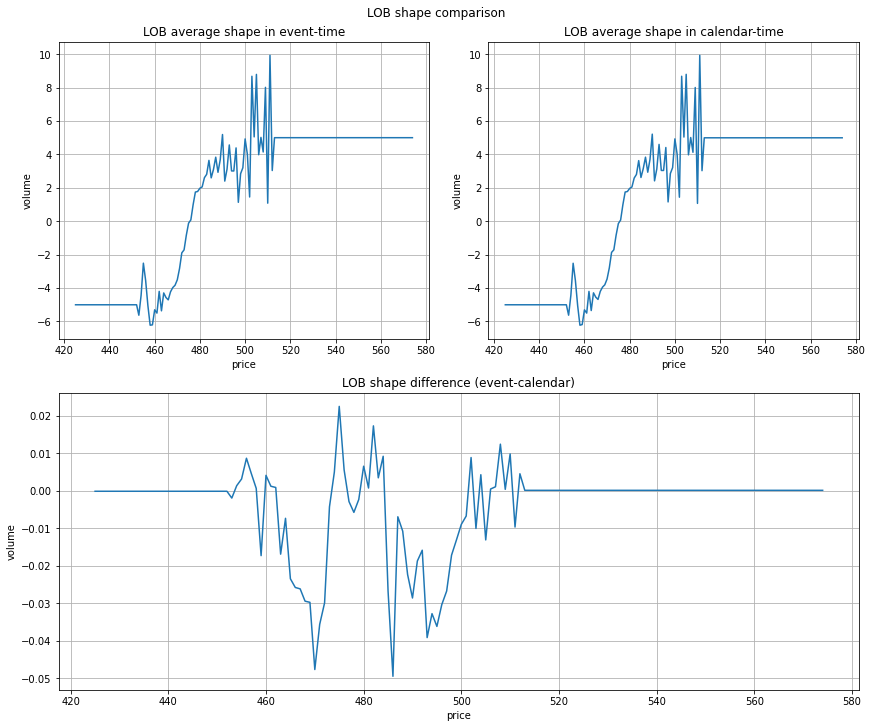

In [ ]:
axs = plot_average_LOB_shape(T, zoom=425)

<b><u>Comments.</b></u>

As the current price never reaches the border of the LOB simulation, the average LOB is flat on each side.

The calendar-time and event-time present minor disprepancies around the fluctuating price.

### 2.2 Plot the spread distribution.

### 2.3 Plot the mid-price variation at a large scale.

### 2.4 Plot the distribution of mid-price increments for several sampling periods. Comment.

### 2.5 Plot the autocorrelation function of the mid-price increments. Comment.

### 2.6 Plot the variance of mid-price increments as a function of the sampling period. Comment.